In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
plt.rcParams['figure.figsize'] = 18, 5

# MEAN FIELD FRAMEWORK FOR SPIKING NETWORK

**Teo Stocco** / supervisor **Alex Seeholzer**

## Today's menu

1. wrap-up
- framework overview
- simple cases continued
- STP & two populations
- full Brunel Wang 2001
- conclusion


## 1 Wrap-up

- goal: compare meanfield theory *vs* simulation
- why: multiple interfaces, error-prone, complex modelling 
- how: common interface, easily swappable/customizable
- under the hood: Brian2 simulator
- applied goal: Brunel Wang 2001

## Brunel Wang 2001

![](img/fig1-brunel-wang-2001.png)

## 2 Framework overview

![](img/overview.svg)

## Populations

![](img/hierarchy-populations.svg)

## Inputs

![](img/hierarchy-inputs.svg)

## Solver

![](img/solver.svg)

## Other points

- connectivity schemes: all-to-all, all-to-one, probability, etc.
- standard parameters
- units checking, both theory and simulation
- solve for any parameter (e.g. $\mu$, $v_{mean}$, $g_{AMPA}$), even specific
- modelling & plotting utilities

**$\to$ easily extensible**

In [2]:
from brian2.units import *
from brian2 import PopulationRateMonitor, defaultclock
from meanfield.modelling import seed
seed(2)

## 3 Noise only

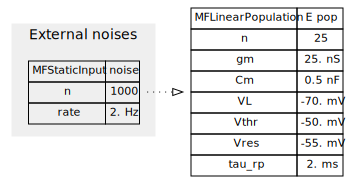

In [3]:
from meanfield import *

population = MFLinearPopulation(25, {
    PP.GM: 25. * nS,
    PP.CM: 0.5 * nF,
    PP.VL: -70. * mV,
    PP.VTHR: -50. * mV,
    PP.VRES: -55. * mV,
    PP.TAU_RP: 2. * ms
}, name='E pop')

MFStaticInput(1000, 2 * Hz, population, {
    IP.GM: 2.08 * nS,
    IP.VREV: 0 * volt,
    IP.TAU: 2. * ms,
}, name='noise')

system = MFSystem(population)
system.graph(details=True)

In [4]:
system.reset_lazyness()

In [5]:
# simulate
monitor = PopulationRateMonitor(population.brian2)
net = system.collect_brian2_network(monitor)
net.run(5 * second)

# extract median by avoiding border effects
margin = round(0.5 * second / defaultclock.dt)
stable = monitor.smooth_rate(width=20 * ms)[margin:-margin]
mu_simu = np.median(stable)
mu_simu

5.58853136 * hertz

In [6]:
solver = MFSolver.rates_voltages(system, solver='simplex')
mu_theo, = solver.run().state
mu_theo

INFO:solver:initializing minimization with simplex
INFO:solver:finished successfully
INFO:solver:solver took 0.077s


5.56319738 * hertz

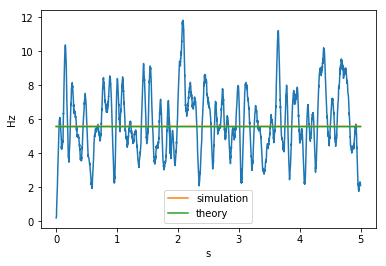

In [7]:
plt.plot(monitor.t, monitor.smooth_rate(width=20 * ms))
plt.plot(monitor.t, np.ones_like(monitor.t) * mu_simu, label='simulation')
plt.plot(monitor.t, np.ones_like(monitor.t) * mu_theo, label='theory')
plt.xlabel('s')
plt.ylabel('Hz')
plt.legend();

## Theory vs simulation comparison



## High regimes



## 4 STP & Two populations

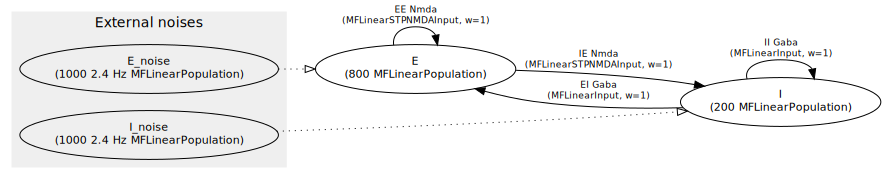

In [8]:
from meanfield.zoo import brunel_wang_2001_stp

system = brunel_wang_2001_stp.no_subpopulation()
system.graph(details=False)

## Shape prediction over parameter ranges

## 5 Brunel Wang


<img src="img/1000-5-simu-activities.png" style="display:inline" width="500"><img src="img/1000-5-mean-activities.png" style="display:inline" width="500">

<img src="img/1000-5-simu-rates.png" style="display:inline" width="500"><img src="img/1000-5-mean-rates.png" style="display:inline" width="500">

In [9]:
e_parameters = MFParameters({
    PP.GM: 25. * nS,
    PP.CM: 0.5 * nF,
    PP.VL: -70. * mV,
    PP.VTHR: -50. * mV,
    PP.VRES: -55. * mV,
    PP.TAU_RP: 2. * ms
})

In [10]:
ee_nmda_parameters = MFParameters({
    IP.GM: 0.327 * nS,
    IP.VREV: 0. * mV,
    IP.TAU: 100. * ms,
    IP.TAU_NMDA_RISE: 2. * ms,
    IP.ALPHA: 0.5 / ms,
    IP.BETA: 0.062,
    IP.GAMMA: 0.2801,
})

## Modelling tools

In [11]:
e_parametershigh

MFParameters { gm: 25. nS, Cm: 0.5 nF, VL: -70. mV, Vthr: -50. mV, Vres: -55. mV, tau_rp: 2. ms }

In [12]:
ee_nmda_parameters

MFParameters { gm: 0.327 nS, Vrev: 0. V, τ_m: 100. ms, τ_NMDA_rise: 2. ms, α: 0.5 kHz, β: 0.062, γ: 0.2801 }

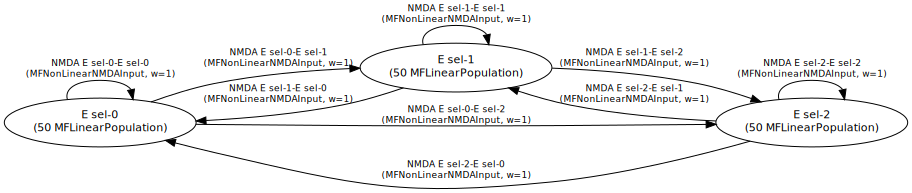

In [13]:
from meanfield import modelling

# populations
pop_e_sel = modelling.multiple_populations(3, MFLinearPopulation, 50, e_parameters, name="E sel")

# connections
modelling.fully_connected(MFNonLinearNMDAInput, pop_e_sel, pop_e_sel, ee_nmda_parameters, name='NMDA')

MFSystem(*pop_e_sel).graph()

## Selective stimuli

![](img/bw-rates.svg)

![](img/bw-activities.svg)

## 6 Conclusion

- hard to design, it works
- easily extendable
- abstract away complexities
- simple and safe way to model
- open source contribution (2 PR, 2 bugs, 1 model)

## Known issues

- Brian2: speed
    - no concurrence, runtime and separate simulations
    - slow network building (even c++)
    - scalability issues
- high regimes unmatch
- sometime hard to converge
- difficult to test

## Further improvements

- develop more precise estimations of simulations
- more tests, more cases
- implement current-based models
- compare with other theories (e.g. Fourcauld & Brunel)
- speed up by better distributing/scheduling
- save/load/share models

## Thanks!

Work available and *usable* on Github [flinz/meanfield-suite](https://github.com/flinz/meanfield-suite).

## References

- GERSTNER, Wulfram, KISTLER, Werner M., NAUD, Richard, et al. Neuronal dynamics: From single neurons to networks and models of cognition. Cambridge University Press, 2014.
- SEEHOLZER, Alexander. Continuous attractor working memory and provenance of channel models. EPFL, 2017.
- TSODYKS, Misha, PAWELZIK, Klaus, et MARKRAM, Henry. Neural networks with dynamic synapses. Neural computation, 1998.
- FOURCAUD, Nicolas et BRUNEL, Nicolas. Dynamics of the firing probability of noisy integrate-and-fire neurons. Dynamics, 2006. 
- BRUNEL, Nicolas et WANG, Xiao-Jing. Effects of neuromodulation in a cortical network model of object working memory dominated by recurrent inhibition. Journal of computational neuroscience, 2001. 
- AMIT, Daniel J. et BRUNEL, Nicolas. Model of global spontaneous activity and local structured activity during delay periods in the cerebral cortex. Cerebral cortex, 1997.